In [22]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
from shapely import box
from scipy.stats import ks_2samp

import config.settings as cset

import matplotlib
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerTuple
from mpl_toolkits.axes_grid1 import make_axes_locatable
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )

from tqdm.notebook import tqdm


plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['hatch.linewidth'] = cset.hatch_linewidth 
# Set global linewidth for all plotted lines
mpl.rcParams['lines.linewidth'] = cset.linewidth  # adjust as needed

# Set global linewidth for figure borders (spines)
mpl.rcParams['axes.linewidth'] = cset.border_linewidth   # frame around plots
mpl.rcParams['xtick.labelsize'] = labelsize_small
mpl.rcParams['ytick.labelsize'] = labelsize_small
mpl.rcParams['axes.labelsize'] = labelsize_medium
mpl.rcParams['axes.titlesize'] = labelsize_large
mpl.rcParams['legend.fontsize'] = labelsize_medium

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

cset.path_OUT_REVERSIBILITY.mkdir(parents=True, exist_ok=True)


### Load Data

In [23]:
gdp_dfs = [pd.read_csv(cset.path_INTERIM_GDP / file_name) for file_name in cset.GDP_interim_dataset_names]

gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

median_gmt_ds = pd.DataFrame(index=gmt_ds.index)
for scenario in cset.scenarios:
    scenario_cols = [col for col in gmt_ds.columns if col.startswith(scenario)]
    median_gmt_ds[scenario] = gmt_ds[scenario_cols].median(axis=1)

### Reversibility

In [44]:
scenarios_to_check = ['ssp534-over', 'Neg']
offsets = [0.17, 0.15]

# Find peak and +/-0.1°C years per scenario
peak_years = {}
below_peak_years_before = {}
below_peak_years_after = {}

for i, scen in enumerate(scenarios_to_check):
    warming = median_gmt_ds[scen]
    peak_year = warming.idxmax()
    peak_val = warming.loc[peak_year]
    target_temp = peak_val - offsets[i]

    # Find year before peak with temp ≈ 0.1°C below peak
    before_peak = warming.loc[:peak_year - 1]
    year_before = (before_peak - target_temp).abs().idxmin()

    # Find year after peak with temp ≈ 0.1°C below peak
    after_peak = warming.loc[peak_year + 1:]
    year_after = (after_peak - target_temp).abs().idxmin()

    peak_years[scen] = peak_year
    below_peak_years_before[scen] = year_before
    below_peak_years_after[scen] = year_after

damage_type_names = cset.GDP_labels
records = []

for damage_idx, gdp_df in enumerate(gdp_dfs):
    damage_name = damage_type_names[damage_idx]

    for scen in scenarios_to_check:
        gdp_scen_df = gdp_df[gdp_df['scen'] == scen]
        gmt_series = median_gmt_ds[scen]

        for label, year in [
            ('Before', below_peak_years_before[scen]),
            ('Peak', peak_years[scen]),
            ('After', below_peak_years_after[scen])
        ]:
            median_gdp_per_run = (
                gdp_scen_df[gdp_scen_df['year'] == year]
                .groupby('run')['SSP2_diff']
                .median()
            )
            median_gdp_impact = (1 - median_gdp_per_run).median() * 100

            records.append({
                'DamageType': damage_name,
                'Scenario': scen,
                'Year': label,
                'Year numeric': year,
                'MedianGDPloss': median_gdp_impact,
                'GMT': gmt_series.loc[year]
            })
# Define years from 'Neg' scenario
ref_years_dict = {
    'Before': below_peak_years_before['Neg'],
    'Peak': peak_years['Neg'],
    'After': below_peak_years_after['Neg']
}

# Loop through damage types and calculate for 'Ref' at 'Neg' scenario's years
for damage_idx, gdp_df in enumerate(gdp_dfs):
    damage_name = damage_type_names[damage_idx]

    scen = 'Ref'
    gdp_scen_df = gdp_df[gdp_df['scen'] == scen]
    gmt_series = median_gmt_ds[scen]

    for label, year in ref_years_dict.items():
        median_gdp_per_run = (
            gdp_scen_df[gdp_scen_df['year'] == year]
            .groupby('run')['SSP2_diff']
            .median()
        )
        median_gdp_impact = (1 - median_gdp_per_run).median() * 100

        records.append({
            'DamageType': damage_name,
            'Scenario': scen,
            'Year': label,
            'Year numeric': year,
            'MedianGDPloss': median_gdp_impact,
            'GMT': gmt_series.loc[year]
        })

reversibility_df = pd.DataFrame(records)
reversibility_df.to_csv(cset.reversibility_file, index=False)

### Inequality

In [10]:
def compute_ks_pvalues(gdp_dfs, years, sel_var):
    """
    Compute KS-test p-values between 'Ref' and 'Neg' scenarios over time for each GDP dataset.
    
    Returns a DataFrame with columns: ['Dataset', 'Year', 'KS_pvalue']
    """
    records = []

    for i, gdp_df in enumerate(gdp_dfs):
        # Precompute median per iso-year-scenario once, scaled by 100
        median_df = (
            gdp_df
            .groupby(['scen', 'iso', 'year'])[sel_var]
            .median()
            .mul(100)
            .reset_index()
        )
        
        # Remove top 1% outliers per scenario-year (optional)
        # We'll do this filtering dynamically inside the loop per year

        for year in years:
            # Get Ref and Neg medians for this year
            dist_1 = median_df[(median_df['scen'] == 'Ref') & (median_df['year'] == year)][sel_var]
            dist_2 = median_df[(median_df['scen'] == 'Neg') & (median_df['year'] == year)][sel_var]

            # Remove top 1% outliers separately for each distribution
            dist_1 = dist_1[dist_1 <= dist_1.quantile(0.99)]
            dist_2 = dist_2[dist_2 <= dist_2.quantile(0.99)]

            # Compute KS test if both distributions have data, else nan
            if len(dist_1) > 0 and len(dist_2) > 0:
                ks_result = ks_2samp(dist_1, dist_2, alternative='two-sided')
                pval = ks_result.pvalue
            else:
                pval = float('nan')

            records.append({'Dataset': cset.GDP_labels[i], 'Year': year, 'KS_pvalue': pval})

    return pd.DataFrame(records)


def plot_ks_pvalues(ks_df, labelsize_small=10, labelsize_medium=12, labelsize_large=14):
    """
    Plot KS p-values over time from the DataFrame returned by compute_ks_pvalues.
    """
    plt.figure(figsize=(8, 5))
    sns.set_style('whitegrid')
    
    for dataset in ks_df['Dataset'].unique():
        data = ks_df[ks_df['Dataset'] == dataset]
        plt.plot(
            data['Year'], data['KS_pvalue'], marker='o', label=dataset
        )
        
    plt.axhline(0.05, color='gray', linestyle='--', linewidth=1, label='p = 0.05')
    plt.xlabel('Year', fontsize=labelsize_medium)
    plt.ylabel('KS test p-value', fontsize=labelsize_medium)
    plt.title('KS test p-values (Ref vs Neg)', fontsize=labelsize_large)
    # plt.xticks(ks_df['Year'].unique())
    plt.ylim(-0.05, 1.05)
    plt.legend(fontsize=labelsize_small)
    sns.despine()
    plt.tight_layout()
    plt.show()

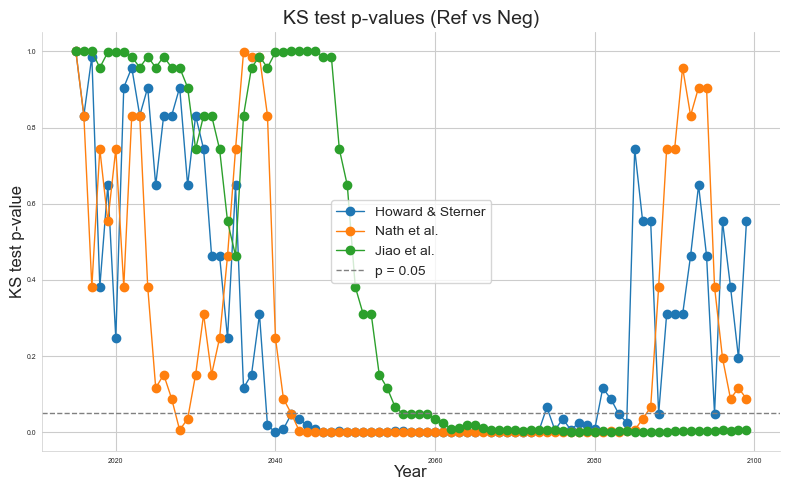

In [11]:
ks_df = compute_ks_pvalues(gdp_dfs, years=np.arange(2015, 2100, 1), sel_var='SSP2_diff')
plot_ks_pvalues(ks_df)
# save ks_df and for each damage funciton, extract first year after peak warming where Ref and Neg are indistinguishable;
ks_df.to_csv(cset.negref_kstest_file) 

In [12]:
def find_first_indistinguishable_year(ks_df, peak_year_neg, pval_threshold=0.05):
    """
    For each damage function (Dataset) find the first year AFTER the Neg peak year
    where KS p-value > pval_threshold (i.e., Ref and Neg indistinguishable).
    
    Parameters:
    - ks_df: DataFrame with columns ['Dataset', 'Year', 'KS_pvalue']
    - peak_year_neg: int, peak year for Neg scenario
    - pval_threshold: float, significance cutoff (default 0.05)
    
    Returns:
    - pandas DataFrame with ['Dataset', 'Year_Indistinguishable']
    """
    results = []

    for dataset in ks_df['Dataset'].unique():
        # Subset for this dataset, and years after peak year
        df_sub = ks_df[(ks_df['Dataset'] == dataset) & (ks_df['Year'] > peak_year_neg)]

        # Filter for p-values > threshold
        df_indist = df_sub[df_sub['KS_pvalue'] > pval_threshold]

        if not df_indist.empty:
            first_year = df_indist['Year'].min()
        else:
            first_year = None  # Or np.nan if preferred

        results.append({'Dataset': dataset, 'Year_Indistinguishable': first_year})

    return pd.DataFrame(results)

neg_peak_year = peak_years['Neg']  # From your earlier computed peak years dict
first_indist_year_df = find_first_indistinguishable_year(ks_df, neg_peak_year)
print(first_indist_year_df)

first_indist_year_df.to_csv(cset.negref_reverseyear_file, index=False)

            Dataset  Year_Indistinguishable
0  Howard & Sterner                  2074.0
1       Nath et al.                  2087.0
2       Jiao et al.                     NaN
